<div style="display: flex; background-color: #196f3d;">
    <h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px; color:#fff;" align="center">Automatically classify consumer goods - P6</h1>
</div>
<div style="display: flex; background-color: #196f3d; margin: auto; padding: 5px 30px 0px 30px;" >
    <h3 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">| Classification Notebook |</h3>
</div>
<div style="display: flex; background-color: #196f3d; margin: auto; padding: 30px 30px 0px 30px;">
    <h4 style="width: 100%; text-align: center; color:white; float: left; font-size: 24px;" align="center">Baptiste LEDESERT</h4>
</div>
<div style="display: flex; background-color: #196f3d; margin: auto; padding: 0px 30px 30px 30px;">
    <h4 style="width: 100%; text-align: center; color:white; float: left; font-size: 24px;" align="center">Data Scientist course - OpenClassrooms</h4>
</div>

<div style="background-color: #229954;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries and functions</h2>
</div>

<div style="background-color: #52be80;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.1. Libraries and functions</h3>
</div>

In [286]:
# Builtin
import os
import shutil 
import glob
import pandas as pd
import numpy as np
import csv
import time
import datetime
from math import pi
import re
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras import metrics as kmetrics
from pathlib import Path

# Traitement image
import cv2
import PIL
from PIL import Image, ImageOps, ImageFilter

# Implementation VGG-16
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, precision_recall_fscore_support
from sklearn import preprocessing
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from plot_keras_history import show_history, plot_history


# Data visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline
import seaborn as sns
from PIL import Image

# Data agumentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Réduction dimensions
from sklearn import manifold, decomposition
from sklearn.manifold import TSNE

# Clustering
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics.cluster import adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score


'''
# -------------------------------------------------------------
# Checking the version numbers of the installed packages
# -------------------------------------------------------------
'''
print('Librairies version : \n')

print('Pandas      : ' + pd.__version__)
print('NumPy       : ' + np.version.full_version)
print('Csv         : ' + csv.__version__ + '\n')

print('Matplotlib  : ' + mpl.__version__)
print('Seaborn     : ' + sns.__version__ + '\n')

now = datetime.datetime.now().isoformat()
print('Launched on : ' + now)

Librairies version : 

Pandas      : 2.0.3
NumPy       : 1.25.2
Csv         : 1.0

Matplotlib  : 3.7.2
Seaborn     : 0.12.2

Launched on : 2024-03-26T11:58:15.520814


In [182]:
# --------------------------------------------------------------------
# Analyse en composantes principales - Réduction de dimension
# --------------------------------------------------------------------

def reduire_dimension_acp(matrice, n_components=0):
    '''
    Analyse en composante principale
    Parameters
    ----------
    matrice : Variable à analyser, obligatoire
    n_components : nombre de composants pour la réduction de dimension
    exemple :  PC1/PC2 et PC3/PC4 ==> [(0, 1), (2, 3)], obligatoire
    affiche_graph : affiche les autres graphiques ; éboulis, distribution...
    Returns
    -------
    None.
    '''
    # Sélection des colonnes pour l'ACP
    cols_acp = matrice.columns.to_list()
    # Nombre de composantes
    if n_components == 0:
        n_comp = len(cols_acp)
    else:
        n_comp = n_components

    # Calcul des composantes principales
    pca = decomposition.PCA(n_components=n_comp)
    pca.fit(matrice)

    # quel est le pourcentage de variance préservé par chacune de
    # nos composantes?
    variances = pca.explained_variance_ratio_

    # quelle est la somme cumulée de chacune de ces variances?
    meilleur_dims = np.cumsum(variances)

    # on va trouver le moment où on atteint 90% ou 95% entre réduire au maxi
    # où garder au maxi

    # argmax pour > 90 %
    best90 = np.argmax(meilleur_dims > 0.9)

    # argmax pour > 95 %
    best = np.argmax(meilleur_dims > 0.95)

    display(f'Nombre de composantes expliquant 90% de la variance : {best90}')
    display(f'Nombre de composantes expliquant 95% de la variance : {best}')

In [183]:
cols = ["VAR1", "VAR2"]

In [184]:
# Dataframe de sauvegarde des résultats des métriques KMeans
df_metrics_kmeans = pd.DataFrame()

In [185]:
# --------------------------------------------------------------------
# -- CALCUL DES METRIQUES K-Means
# --------------------------------------------------------------------

def calcul_metrics_kmeans(data, dataframe_metrique, type_donnees,
                          random_seed, ninit, maxiter):
    '''
    Calcul des métriques de KMeans en fonction de différents paramètres.
    Parameters
    ----------
    data : données, obligatoire.
    dataframe_metrique : dataframe de sauvegarde des résultats, obligatoire.
    type_donnees : string intitulé des données, obligatoire.
    random_seed : nombre aléatoire pour la reproductibilité, obligatoire.
    ninit : nombre de clusters à initialiser, obligatoire.
    maxiter : type d'initialisation : 'k-means++' ou 'random'.
    Returns
    -------
    dataframe_metrique : résultat des métriques
    '''
    # Cette fonction permet de calculer le nombre de clusters le plus
    # optimal pour notre analyse : le coefficient de silhouette,
    # dispersion, indice de davies_bouldin
    silhouette = []
    dispersion = []
    davies_bouldin = []
    donnees = []
    temps = []

    result_ninit = []
    result_maxiter = []

    # Hyperparametre tuning

    ninit = ninit
    maxiter = maxiter

    # Recherche des hyperparamètres
    for var_ninit in ninit:

        for var_maxiter in maxiter:

            # Top début d'exécution
            time_start = time.time()

            # Initialisation de l'algorithme
            cls = KMeans(n_clusters=7,
                         n_init=var_ninit,
                         init='k-means++',
                         max_iter=var_maxiter,
                         random_state=random_seed)

            # Entraînement de l'algorithme
            cls.fit(data)

            # Prédictions
            preds = cls.predict(data)

            # Top fin d'exécution
            time_end = time.time()

            # Calcul du score de coefficient de silhouette
            silh = metrics.silhouette_score(data, preds)
            # Calcul la dispersion
            disp = cls.inertia_
            # Calcul de l'indice davies-bouldin
            db = metrics.davies_bouldin_score(data, preds)
            # Durée d'exécution
            time_execution = time_end - time_start

            silhouette.append(silh)
            dispersion.append(disp)
            davies_bouldin.append(db)
            donnees.append(type_donnees)
            temps.append(time_execution)

            result_ninit.append(var_ninit)
            result_maxiter.append(var_maxiter)

    dataframe_metrique = dataframe_metrique.append(pd.DataFrame({
        'Type_données': donnees,
        'n_init': result_ninit,
        'max_iter': result_maxiter,
        'coef_silh': silhouette,
        'dispersion': dispersion,
        'davies_bouldin': davies_bouldin,
        'Durée (s)': temps
    }), ignore_index=True)

    return dataframe_metrique

In [186]:
# --------------------------------------------------------------------
# SCATTERPLOT DE VISUALISATION DE TRANSFORMATION T-SNE en 2D
# --------------------------------------------------------------------
def affiche_tsne(results_list, liste_param, alpha=0.1):
    '''
    Affiche les résultats de la transformation Lt-SNE
    -----------
    @ Parameters
    * results_list : iste des résultats de la transformation t-SNE
    * liste_param : liste des valeurs de l'hyper paramètre perplexity testées

    -----------
    @ Returns
    * Scatterplots
    '''

    i = 0

    # Visualisation en 2D des différents résultats selon la perplexité
    plt.subplots(6, 2, figsize=[12, 28])

    for resultat_tsne in results_list:
        plt.subplot(6, 2, i + 1)
        tsne_results_i = results_list[i]
        sns.scatterplot(x=tsne_results_i[:, 0], y=tsne_results_i[:, 1],
                        alpha=alpha)
        plt.title('t-SNE avec perplexité=' + str(liste_param[i]))
        plt.grid(False)
        plt.plot()

        i += 1

    plt.show()

In [187]:
# Détermination clusters après PCA et calcul ARI entre
# vrai catégorie et n° de clusters

def ARI_fct(X_proj, init_method, Ninit, m_iter, df_donnees, df_analyse) :

    """
    ----------
    @Paramètres:
    * X_proj : datamatrix
    * df_donnees : df avec l'information des catégories reelles
    * df_analyse: nom du df pour enregistrer les résultats
    """

    # Dataframe pour clustering
    df_analyse = pd.DataFrame({"VAR1" : X_proj[:, 0],
                               "VAR2": X_proj[:, 1],
                               "CATEGORIE" : df_donnees.Categ_N0})

    num_labels=len(l_cat)
    # Instantiation du modèle k-means
    cls = KMeans(n_clusters=num_labels, init=init_method, n_init=Ninit,
                 random_state=seed, max_iter=m_iter)
    cls.fit(df_analyse[cols])
    # Ajout de l'assignation du cluster au dataframe
    df_analyse["Clusters"] = cls.labels_
    kmeans_labels = cls.labels_
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)

    return ARI, kmeans_labels, df_analyse

In [188]:
# ------------------------------------------------------------
# Scatterplot ACP selon les vraies catégories et les clusters
# ------------------------------------------------------------
def dimReduc_visu_fct(X_projected, y_cat_num, labels, ARI, methode):
    '''
    Affiche la projection scatterplot par catégories et clusters.
    -----------
    @Parameters
    * X_projected : Datamatrix après projection, obligatoire.
    * labels : la variable représentant les clusters.
    * methode : str, nom de la methode de reduction de dimensions
    --------
    @Returns
    Scatterplots
    '''
    fig = plt.figure(figsize=(15, 6))

    # Scatterplot des catégories
    ax = fig.add_subplot(121)
    scatter = ax.scatter(x=X_projected[:, 0], y=X_projected[:, 1],
                         c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0],
              labels=l_cat, loc="best", title="Categorie")
    plt.title(methode + 'Représentation par catégories réelles')

    # Scatterplot des clusters
    ax = fig.add_subplot(122)
    scatter = ax.scatter(x=X_projected[:, 0], y=X_projected[:, 1],
                         c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels),
              loc="best", title="Clusters")
    plt.title(methode + 'Représentation par clusters')

    plt.show()
    print("ARI : ", ARI)

In [339]:
def evaluate_model_generator(model, test_generator):
    # Obtenir les prédictions pour l'ensemble de test
    y_pred = model.predict(test_generator)
    y_pred_classes = tf.argmax(y_pred, axis=1)

    # Convertir les étiquettes en vecteurs de classe
    y_true = test_generator.classes


    # Obtenir les noms de classe pour les étiquettes réelles
    class_names = list(test_generator.class_indices.keys())

    
    # Calculer la matrice de confusion
    confusion_mtx = confusion_matrix(y_true, y_pred_classes)

    # Afficher la matrice de confusion sous forme graphique
    sns.heatmap(confusion_mtx, xticklabels=class_names, yticklabels=class_names, cmap='Blues', annot=True, fmt='d')
    plt.title('Matrice de confusion')
    plt.xlabel('Prédictions')
    plt.ylabel('Valeurs réelles')
    plt.show()

    # Afficher le rapport de classification
    print(classification_report(y_true, y_pred_classes, target_names=class_names))
    
    return(precision_recall_fscore_support(y_true, y_pred_classes, average='weighted'))

In [347]:
y_pred = model2.predict(test_flow)
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_classes

157/157 [==============================] - 16s 104ms/step


array([4, 3, 3, 3, 1, 6, 0, 4, 1, 5, 4, 4, 3, 3, 5, 6, 5, 3, 2, 3, 0, 3,
       6, 4, 1, 6, 3, 5, 2, 3, 0, 2, 2, 3, 1, 2, 4, 2, 1, 5, 4, 5, 2, 3,
       1, 6, 6, 5, 3, 5, 2, 1, 6, 3, 0, 2, 4, 5, 0, 5, 5, 3, 0, 4, 1, 4,
       4, 0, 6, 6, 3, 1, 5, 5, 0, 6, 5, 0, 4, 1, 1, 5, 0, 3, 2, 3, 6, 2,
       6, 0, 1, 6, 1, 0, 4, 4, 0, 0, 0, 1, 5, 0, 2, 5, 0, 6, 2, 6, 6, 4,
       1, 4, 6, 5, 3, 6, 5, 2, 1, 4, 2, 4, 2, 1, 5, 6, 6, 6, 3, 5, 4, 2,
       6, 2, 2, 0, 2, 5, 5, 3, 4, 5, 4, 3, 2, 5, 4, 1, 3, 1, 2, 1, 4, 4,
       5, 0, 6], dtype=int64)

In [357]:
y_pred_classes_list = y_pred_classes.tolist()

In [354]:
y_true = test_flow.classes
type(y_true)


list

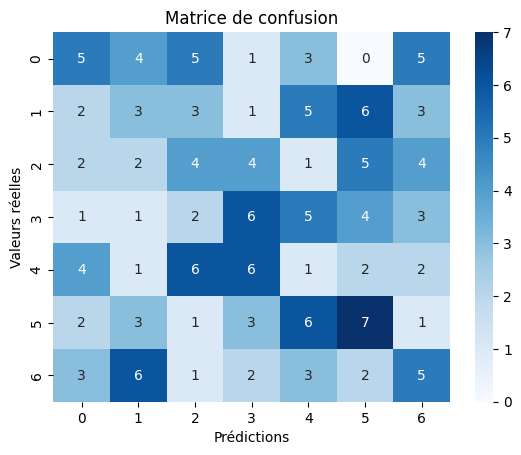

In [359]:
confusion_mtx = confusion_matrix(y_true, y_pred_classes_list)
sns.heatmap(confusion_mtx, cmap='Blues', annot=True, fmt='d')
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.show()

In [333]:
def evaluate_model_dataset(model, dataset, name=None):
    y_true = []
    y_pred = []
    for x,y in dataset:
      y= tf.argmax(y,axis=1)
      y_true.append(y)
      y_pred.append(tf.argmax(model.predict(x, verbose=0),axis = 1))
      
    y_pred = tf.concat(y_pred, axis=0)
    y_true = tf.concat(y_true, axis=0)
    conf_mat=confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(conf_mat, index=[categ for categ in categories_liste],
                         columns=[i for i in "0123456"])
    plt.figure(figsize=(6, 4))
    
    # Afficher la matrice de confusion sous forme graphique
    sns.heatmap(df_cm, annot=True, cmap="Blues")
    plt.title('Matrice de confusion')
    plt.xlabel('Prédictions')
    plt.ylabel('Valeurs réelles')
    plt.savefig("images/graph/conf_mat_" + name +".png")
    plt.show()
    # Afficher le rapport de classification
    print(classification_report(y_true, y_pred))
    return(precision_recall_fscore_support(y_true, y_pred_classes, average='weighted'))

<div style="background-color: #52be80;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.2. Parametrisation</h3>
</div>

In [190]:
# Parameters used in this notebook
seed = 84

%pycodestyle_off

<div style="background-color: #229954;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Database</h2>
</div>

In [191]:
data_image = pd.read_csv('data_image.csv')

In [192]:
data_image.head()

,image,Categ_N0,description,cat_label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,Key Features of Elegance Polyester Multicolor ...,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,Specifications of Sathiyas Cotton Bath Towel (...,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,Key Features of Eurospa Cotton Terry Face Towe...,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,Key Features of SANTOSH ROYAL FASHION Cotton P...,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,Key Features of Jaipur Print Cotton Floral Kin...,4


In [193]:
# Dossier contenant les images disponibles
path_images = "images/Images/"

# Taille redimensionement
dim = (224, 224)

In [194]:
# Liste des vraies catégories
categories_liste = list(set(data_image["Categ_N0"]))
df_classif_superv = data_image[["image", "Categ_N0", "cat_label"]].copy()

In [195]:
categories_liste

['Computers',
 'Baby Care',
 'Watches',
 'Beauty and Personal Care',
 'Kitchen & Dining',
 'Home Furnishing',
 'Home Decor & Festive Needs']

In [196]:
# Création d'un set d'entraînement et un set de test

X = df_classif_superv[["image"]]
y = df_classif_superv["cat_label"]

images, img_tv, categories, categ_tv = train_test_split(X, y,
                                                            stratify=y,
                                                            test_size=0.20,
                                                            random_state=seed)

In [197]:
# Recalculer les index pour avoir des listes de valeurs continus
images = images.reset_index()
print("images train", images.shape)

img_tv = img_tv.reset_index()
print("images test", img_tv.shape)

images train (840, 2)
images test (210, 2)


<Axes: xlabel='cat_label'>

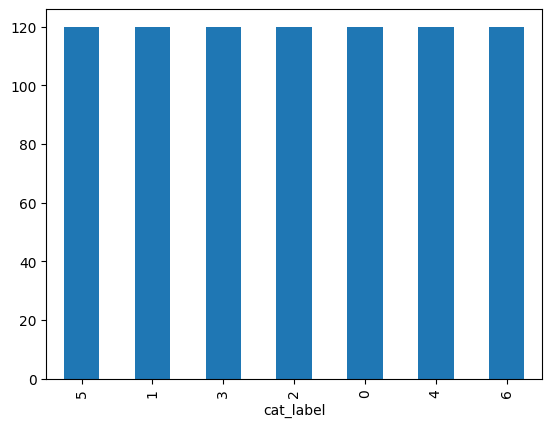

In [198]:
# Visualisation de la representation des catégories dans le set qui servira
# à l'entraînement et validation
categories.value_counts().plot(kind="bar")
plt.savefig("images/graph/categories_set_train.png")

<Axes: xlabel='cat_label'>

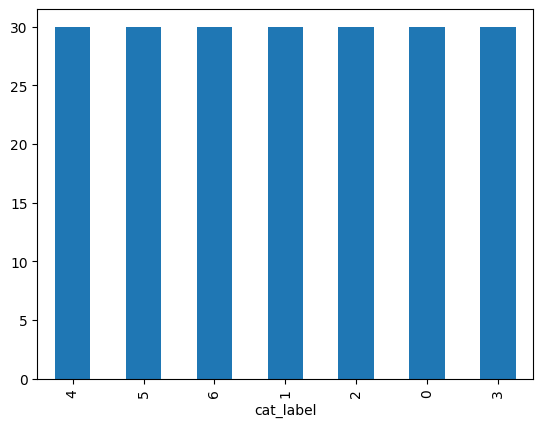

In [199]:
# Visualisation de la representation des catégories dans le set qui servira
# au test
categ_tv.value_counts().plot(kind="bar")
plt.savefig("images/graph/categories_set_test.png")

<div style="background-color: #229954;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Classification supervisée</h2>
</div>

3 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images
* Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
* Une approche par DataSet, avec data augmentation intégrée au modèle : layer en début de modèle

In [200]:
# Liste pour enregistrer les informations nécessaires
#  à la comparaison des performances
approach = []
loss_vali_opt = []
accuracy_vali_opt = []
loss_test_opt = []
accuracy_test_opt = []
time_fit = []

<div style="background-color: #52be80;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.1. Création du modèle de classification</h3>
</div>

In [201]:
def create_model_VGG16_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet",
                   input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop',
                  metrics=["accuracy"])

    print(model.summary())
    
    return model

<div style="background-color: #52be80;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.2. Approche préparation initiale des images</h3>
</div>

In [202]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['image'])) :
        img = (load_img(path_images+
            data['image'][image_num],
            target_size=dim))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np

images_np = image_prep_fct(images)
print(images_np.shape)
images_np_tv = image_prep_fct(img_tv)
print(images_np_tv.shape)

C:\Python\Python311\Lib\site-packages\PIL\Image.py:3157: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(840, 224, 224, 3)
(210, 224, 224, 3)


In [203]:
X_model_np = images_np
y_model_np = to_categorical(categories)

img_tv_np = images_np_tv
categ_tv_np = to_categorical(categ_tv)

In [204]:
# Creation des jeux de donnéées, en batch pour traitement. Tv pour Test ET Validation.
# les deux jeux seront separ2s dans un deuxième temps

img_test_np, img_val_np, categ_test_np, categ_val_np = train_test_split(img_tv_np, categ_tv_np,
                                                              stratify=categ_tv_np,
                                                              test_size=0.25,
                                                              random_state=seed)

In [205]:
# Création du modèle
model1 = create_model_VGG16_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss',
                             verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [206]:
# Entraîner sur les données d'entraînement (img_train, categ_train)
start_time=time.time()
history1 = model1.fit(X_model_np, y_model_np, epochs=50, batch_size=64,
                      callbacks=callbacks_list, validation_data=(img_val_np,
                                                                 categ_val_np),
                      verbose=1)
tps_exec_model1 = round(time.time() - start_time,3)

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 4.6286 - accuracy: 0.4833
Epoch 1: val_loss improved from inf to 1.32824, saving model to .\model1_best_weights.h5
14/14 [==============================] - 75s 5s/step - loss: 4.6286 - accuracy: 0.4833 - val_loss: 1.3282 - val_accuracy: 0.7358
Epoch 2/50


C:\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - ETA: 0s - loss: 1.9199 - accuracy: 0.6940
Epoch 2: val_loss improved from 1.32824 to 1.01932, saving model to .\model1_best_weights.h5
14/14 [==============================] - 73s 5s/step - loss: 1.9199 - accuracy: 0.6940 - val_loss: 1.0193 - val_accuracy: 0.7736
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 1.1191 - accuracy: 0.7571
Epoch 3: val_loss did not improve from 1.01932
14/14 [==============================] - 74s 5s/step - loss: 1.1191 - accuracy: 0.7571 - val_loss: 1.0212 - val_accuracy: 0.7925
Epoch 4/50
14/14 [==============================] - ETA: 0s - loss: 0.8832 - accuracy: 0.7798
Epoch 4: val_loss improved from 1.01932 to 1.01553, saving model to .\model1_best_weights.h5
14/14 [==============================] - 75s 5s/step - loss: 0.8832 - accuracy: 0.7798 - val_loss: 1.0155 - val_accuracy: 0.8302
Epoch 5/50
14/14 [==============================] - ETA: 0s - loss: 0.6131 - accuracy: 0.8226
Epoch 5: val_lo

In [207]:
# Score du dernier epoch
loss, accuracy = model1.evaluate(X_model_np, y_model_np, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()

loss, accuracy = model1.evaluate(img_val_np, categ_val_np, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

27/27 [==============================] - 71s 3s/step - loss: 0.0131 - accuracy: 0.9976
Training Accuracy: 0.9976

2/2 [==============================] - 4s 2s/step - loss: 0.9603 - accuracy: 0.8491
Validation Accuracy:  0.8491


In [208]:
# Score de l'epoch optimal
model1.load_weights(model1_save_path1)
loss_vali_model1, accuracy_vali_model1 = model1.evaluate(img_val_np, categ_val_np,
                                                         verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_vali_model1))

loss_test_model1, accuracy_test_model1 = model1.evaluate(img_test_np, categ_test_np,
                                                         verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_model1))

Validation Accuracy :  0.8302
Test Accuracy       :  0.8089


In [209]:
# Information à garder pour la comparaison des performances

approach.append("Prep_Init")
loss_vali_opt.append(loss_vali_model1)
accuracy_vali_opt.append(accuracy_vali_model1)
loss_test_opt.append(loss_test_model1)
accuracy_test_opt.append(accuracy_test_model1)
time_fit.append(tps_exec_model1)

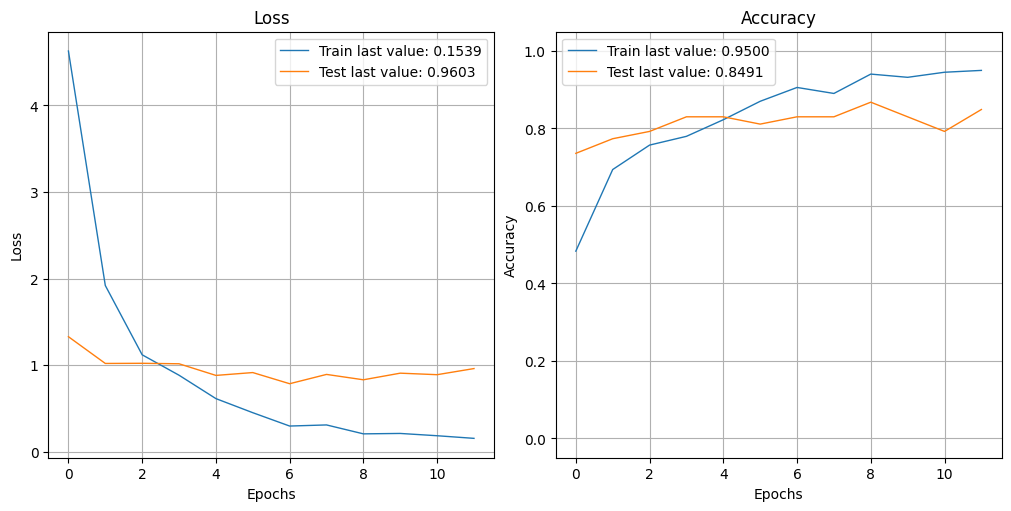

In [210]:
show_history(history1)
plot_history(history1, path="standard.png")
plt.savefig("images/graph/history_plot_model1.png")
plt.close()

In [211]:
categ_val_num = np.argmax(categ_val_np, axis=1)
categ_val_pred = np.argmax(model1.predict(img_val_np), axis=1)

print(categ_val_num)
print()
print(categ_val_pred)

2/2 [==============================] - 5s 2s/step
[1 3 5 4 4 5 5 4 6 5 2 2 4 4 5 3 3 0 1 5 1 1 0 4 1 6 5 6 1 2 2 5 2 4 0 6 0
 3 6 6 3 2 1 0 3 1 2 3 4 6 0 6 0]

[1 4 2 4 4 5 5 3 6 5 2 2 4 4 5 3 3 0 1 5 1 1 0 0 1 6 5 6 3 2 3 5 2 4 0 6 4
 3 6 6 3 2 1 0 3 1 3 4 4 6 0 6 0]


In [213]:
def conf_mat_transform(y_true, y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [329]:
conf_mat = metrics.confusion_matrix(categ_val_num, categ_val_pred)
# print(conf_mat)

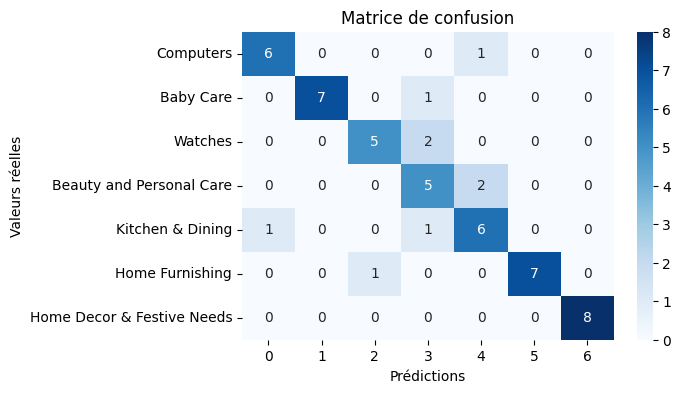

In [336]:
df_cm = pd.DataFrame(conf_mat, index=[categ for categ in categories_liste],
                     columns=[i for i in "0123456"])
plt.figure(figsize=(6, 4))

sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.savefig("images/graph/conf_mat_model1.png")

plt.show()

In [328]:
categ_val_pred_transform = conf_mat_transform(categ_val_num, categ_val_pred)
conf_mat = metrics.confusion_matrix(categ_val_num, categ_val_pred_transform)

print(metrics.classification_report(categ_val_num, categ_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       1.00      0.88      0.93         8
           2       0.83      0.71      0.77         7
           3       0.56      0.71      0.63         7
           4       0.67      0.75      0.71         8
           5       1.00      0.88      0.93         8
           6       1.00      1.00      1.00         8

    accuracy                           0.83        53
   macro avg       0.84      0.83      0.83        53
weighted avg       0.85      0.83      0.84        53



<div style="background-color: #52be80;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.3. Approche ImageDatagenerator avec data augmentation</h3>
</div>
CF https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow (noté désormais comme "deprecated", incite à utiiser l'approche suivante)

In [216]:
# # Pour mélanger les images, éviter le classement par classe
# df_reference = df_reference.sample(frac=1, random_state=42)\
#                                     .reset_index(drop=True)
batch_size = 32

# Sélectionner les caractéristiques et les étiquettes
X = df_classif_superv["image"]
y = df_classif_superv["cat_label"].astype(str)

# Diviser en ensembles d'entraînement et de test
X_train, X_tv, y_train, y_tv = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Diviser l'ensemble de test en ensembles de test et de validation
X_test, X_val, y_test, y_val = train_test_split(X_tv, y_tv, test_size=0.25, random_state=42, stratify = y_tv)

In [217]:
y_test

1006    1
869     4
625     3
968     0
1021    2
       ..
187     5
744     5
779     1
2       0
400     2
Name: cat_label, Length: 157, dtype: object

In [218]:
df_train = pd.DataFrame({"image": X_train, "cat_label": y_train})
df_test = pd.DataFrame({"image": X_test, "cat_label": y_test})
df_val = pd.DataFrame({"image": X_val, "cat_label": y_val})

In [219]:
def data_flow_fct(data, datagen, data_type=None, batch_size=batch_size) :
    data_flow = datagen.flow_from_dataframe(data, directory=path_images,
                                x_col='image', y_col='cat_label',
                                weight_col=None, target_size=(224, 224),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=seed
                                )
    return data_flow

In [220]:
datagen_train = ImageDataGenerator(
    #  featurewise_center=True,
    #  featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(df_train, datagen_train)
val_flow = data_flow_fct(df_val, datagen_train)

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(df_test, datagen_test, data_type=None, batch_size=1)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 840 validated image filenames belonging to 7 classes.
Found 53 validated image filenames belonging to 7 classes.
Found 157 validated image filenames belonging to 7 classes.


In [221]:
# Création du modèle

model2 = create_model_VGG16_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [222]:
start_time = time.time()
history2 = model2.fit(train_flow,
                      validation_data=val_flow,
                      batch_size=batch_size, epochs=50,
                      callbacks=callbacks_list,
                      verbose=1)
tps_exec_model2 = round(time.time() - start_time,3)

Epoch 1/50
 6/27 [=====>........................] - ETA: 1:00 - loss: 7.5373 - accuracy: 0.2292

C:\Python\Python311\Lib\site-packages\PIL\Image.py:3157: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


27/27 [==============================] - ETA: 0s - loss: 4.1592 - accuracy: 0.4607
Epoch 1: val_loss improved from inf to 1.67467, saving model to .\model2_best_weights.h5
27/27 [==============================] - 82s 3s/step - loss: 4.1592 - accuracy: 0.4607 - val_loss: 1.6747 - val_accuracy: 0.6792
Epoch 2/50


C:\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - ETA: 0s - loss: 1.6407 - accuracy: 0.6500
Epoch 2: val_loss improved from 1.67467 to 1.24127, saving model to .\model2_best_weights.h5
27/27 [==============================] - 81s 3s/step - loss: 1.6407 - accuracy: 0.6500 - val_loss: 1.2413 - val_accuracy: 0.6981
Epoch 3/50
27/27 [==============================] - ETA: 0s - loss: 1.0511 - accuracy: 0.7357
Epoch 3: val_loss improved from 1.24127 to 1.00135, saving model to .\model2_best_weights.h5
27/27 [==============================] - 86s 3s/step - loss: 1.0511 - accuracy: 0.7357 - val_loss: 1.0013 - val_accuracy: 0.7547
Epoch 4/50
27/27 [==============================] - ETA: 0s - loss: 0.8748 - accuracy: 0.7583
Epoch 4: val_loss improved from 1.00135 to 0.66993, saving model to .\model2_best_weights.h5
27/27 [==============================] - 88s 3s/step - loss: 0.8748 - accuracy: 0.7583 - val_loss: 0.6699 - val_accuracy: 0.7736
Epoch 5/50
27/27 [==============================] - ETA: 0s - l

In [223]:
# Score du dernier epoch
loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()

loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

27/27 [==============================] - 72s 3s/step - loss: 0.1392 - accuracy: 0.9536
Training Accuracy   : 0.9536

2/2 [==============================] - 5s 2s/step - loss: 1.1135 - accuracy: 0.7925
Validation Accuracy :  0.7925


In [224]:
# Score de l'epoch optimal
model2.load_weights(model2_save_path)

loss_vali_model2, accuracy_vali_model2 = model2.evaluate(val_flow,
                                                         verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_vali_model2))

loss_test_model2, accuracy_test_model2 = model2.evaluate(test_flow,
                                                         verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_model2))

Validation Accuracy :  0.7736
Test Accuracy       :  0.8217


In [225]:
# Information à garder pour la comparaison des performances

approach.append("ImgDataGenerator")
loss_vali_opt.append(loss_vali_model2)
accuracy_vali_opt.append(accuracy_vali_model2)
loss_test_opt.append(loss_test_model2)
accuracy_test_opt.append(accuracy_test_model2)
time_fit.append(tps_exec_model2) 

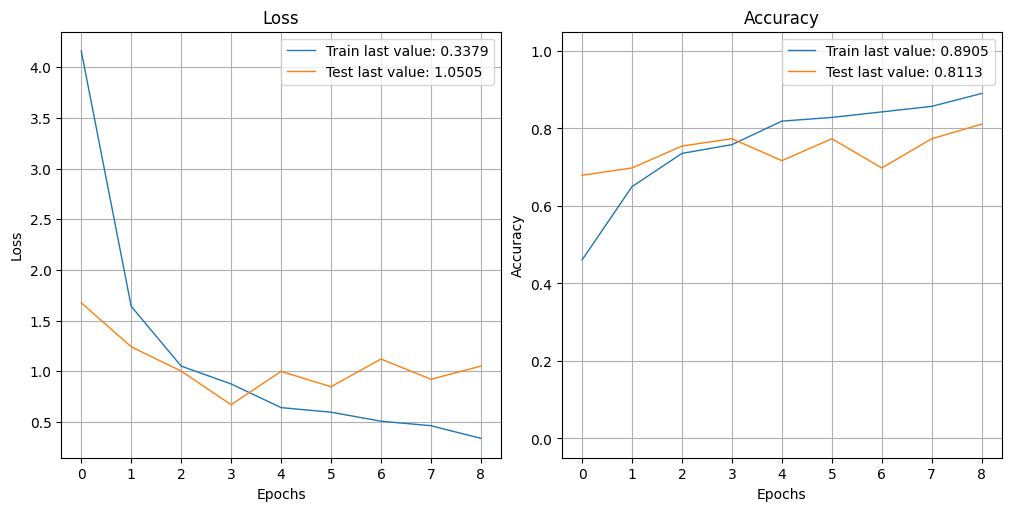

In [226]:
show_history(history2)
plot_history(history2, path="standard.png")
plt.savefig("images/graph/history_plot_model2.png")
plt.close()

157/157 [==============================] - 16s 98ms/step


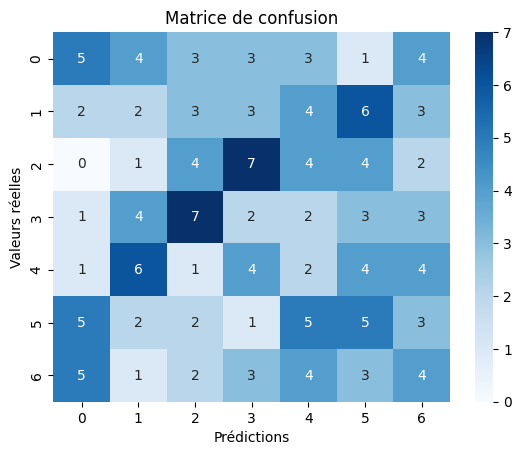

              precision    recall  f1-score   support

           0       0.26      0.22      0.24        23
           1       0.10      0.09      0.09        23
           2       0.18      0.18      0.18        22
           3       0.09      0.09      0.09        22
           4       0.08      0.09      0.09        22
           5       0.19      0.22      0.20        23
           6       0.17      0.18      0.18        22

    accuracy                           0.15       157
   macro avg       0.15      0.15      0.15       157
weighted avg       0.16      0.15      0.15       157



(0.15508389980981038, 0.15286624203821655, 0.15343511500547358, None)

In [338]:
evaluate_model_generator(model2, test_flow)

<div style="background-color: #52be80;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.4. Approche nouvelle par Dataset sans data augmentation</h3>
</div>

CF https://www.tensorflow.org/tutorials/load_data/images

<div style="background-color: #52be80;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.4.1. Modification structure dossier images</h4><a name="ponctuation_nonAlpha"></a>
</div>

In [227]:
# Création des sous dossiers par catégorie
col = "Categ_N0"

# Dictionary mapping numerical labels to categorical values
label_to_category = {
    '0': 'Baby Care',
    '1': 'Beauty and Personal Care',
    '2': 'Computers',
    '3': 'Home Decor & Festive Needs',
    '4': 'Home Furnishing',
    '5': 'Kitchen & Dining',
    '6': 'Watches'
}
df_train_categ = df_train.copy()
df_train_categ['Categ_N0'] = df_train_categ['cat_label'].map(label_to_category)

df_test_categ = df_test.copy()
df_test_categ['Categ_N0'] = df_test_categ['cat_label'].map(label_to_category)

df_val_categ = df_val.copy()
df_val_categ['Categ_N0'] = df_val_categ['cat_label'].map(label_to_category)


# for value in df_train_categ[col]:
#     Path(f'images/Images/img_subfolder/train_img/{value}')\
#           .mkdir(parents=True, exist_ok=True)

# for value in df_test_categ[col]:
#     Path(f'images/Images/img_subfolder/test_img/{value}')\
#           .mkdir(parents=True, exist_ok=True)

# for value in df_val_categ[col]:
#     Path(f'images/Images/img_subfolder/val_img/{value}')\
#           .mkdir(parents=True, exist_ok=True)

In [228]:
train_img_directory = "images/Images/img_subfolder/train_img/"

In [229]:
# df_train_categ.apply(lambda row: shutil.copyfile('images/Images/'+row['image'],
#                                                (train_img_directory +
#                                                 row['Categ_N0']+ '//' +
#                                                 row['image'])), axis=1)

In [230]:
test_directory = "images/Images/img_subfolder/test_img/"

In [231]:
# df_test_categ.apply(lambda row: shutil.copyfile('images/Images/'+row['image'], (test_directory +
#                                                              row['Categ_N0']+
#                                                              '//'
#                                                               + row['image'])),
#                axis=1)

In [232]:
val_directory = "images/Images/img_subfolder/val_img/"

In [233]:
# df_val_categ.apply(lambda row: shutil.copyfile('images/Images/'+row['image'], (val_directory +
#                                                              row['Categ_N0']+
#                                                              '//'
#                                                               + row['image'])),
#                axis=1)

<div style="background-color: #52be80;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.4.2. Application approche par Dataset</h4><a name="ponctuation_nonAlpha"></a>
</div>

In [234]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tensorflow.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=32, image_size=(224, 224),
                    shuffle=True, seed=42,
                    subset=data_type
                    )
    return dataset


In [235]:
dataset_train = dataset_fct(train_img_directory)
dataset_val = dataset_fct(val_directory)
dataset_test = dataset_fct(test_directory)

Found 840 files belonging to 7 classes.
Found 53 files belonging to 7 classes.
Found 157 files belonging to 7 classes.


In [236]:
# Création du modèle
with tensorflow.device('/gpu:0'):
    model3 = create_model_VGG16_fct()

# Création du callback
model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [237]:
start_time = time.time()
history3 = model3.fit(dataset_train,
                      validation_data=dataset_val,
                      batch_size=batch_size, epochs=50,
                      callbacks=callbacks_list,
                      verbose=1)
tps_exec_model3 = round(time.time() - start_time,3)

Epoch 1/50
27/27 [==============================] - ETA: 0s - loss: 5.4402 - accuracy: 0.5036
Epoch 1: val_loss improved from inf to 1.22086, saving model to .\model3_best_weights.h5
27/27 [==============================] - 78s 3s/step - loss: 5.4402 - accuracy: 0.5036 - val_loss: 1.2209 - val_accuracy: 0.6792
Epoch 2/50


C:\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - ETA: 0s - loss: 2.1199 - accuracy: 0.6833
Epoch 2: val_loss did not improve from 1.22086
27/27 [==============================] - 75s 3s/step - loss: 2.1199 - accuracy: 0.6833 - val_loss: 1.2758 - val_accuracy: 0.7358
Epoch 3/50
27/27 [==============================] - ETA: 0s - loss: 1.4152 - accuracy: 0.7548
Epoch 3: val_loss improved from 1.22086 to 1.06862, saving model to .\model3_best_weights.h5
27/27 [==============================] - 76s 3s/step - loss: 1.4152 - accuracy: 0.7548 - val_loss: 1.0686 - val_accuracy: 0.7547
Epoch 4/50
27/27 [==============================] - ETA: 0s - loss: 0.9137 - accuracy: 0.7940
Epoch 4: val_loss improved from 1.06862 to 0.86888, saving model to .\model3_best_weights.h5
27/27 [==============================] - 75s 3s/step - loss: 0.9137 - accuracy: 0.7940 - val_loss: 0.8689 - val_accuracy: 0.7736
Epoch 5/50
27/27 [==============================] - ETA: 0s - loss: 0.6908 - accuracy: 0.8226
Epoch 5: val_lo

In [238]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

27/27 [==============================] - 71s 3s/step - loss: 0.0137 - accuracy: 0.9964
Training Accuracy   : 0.9964

2/2 [==============================] - 5s 2s/step - loss: 1.0566 - accuracy: 0.8113
Validation Accuracy :  0.8113


In [239]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss_vali_model3, accuracy_vali_model3 = model3.evaluate(dataset_val,
                                                         verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_vali_model3))

loss_test_model3, accuracy_test_model3 = model3.evaluate(dataset_test,
                                                         verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_model3))

Validation Accuracy :  0.8113
Test Accuracy       :  0.8153


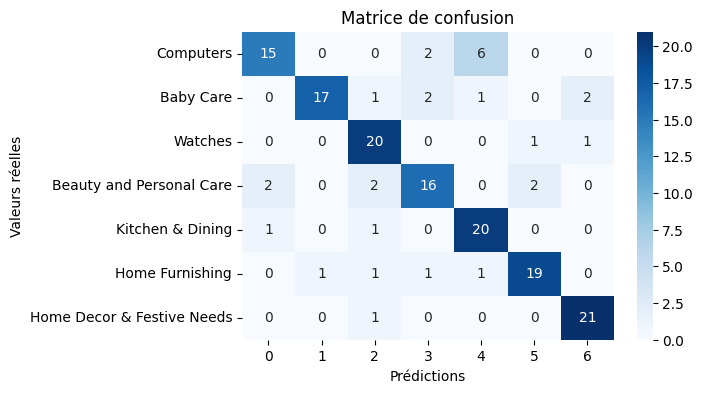

              precision    recall  f1-score   support

           0       0.83      0.65      0.73        23
           1       0.94      0.74      0.83        23
           2       0.77      0.91      0.83        22
           3       0.76      0.73      0.74        22
           4       0.71      0.91      0.80        22
           5       0.86      0.83      0.84        23
           6       0.88      0.95      0.91        22

    accuracy                           0.82       157
   macro avg       0.82      0.82      0.81       157
weighted avg       0.82      0.82      0.81       157



(0.11580428115736893, 0.12101910828025478, 0.11809529223788498, None)

In [335]:
evaluate_model_dataset(model3, dataset_test, name="model3")

In [240]:
# Information à garder pour la comparaison des performances

approach.append("New_approach_without_dataAugm")
loss_vali_opt.append(loss_vali_model3)
accuracy_vali_opt.append(accuracy_vali_model3)
loss_test_opt.append(loss_test_model3)
accuracy_test_opt.append(accuracy_test_model3)
time_fit.append(tps_exec_model3)

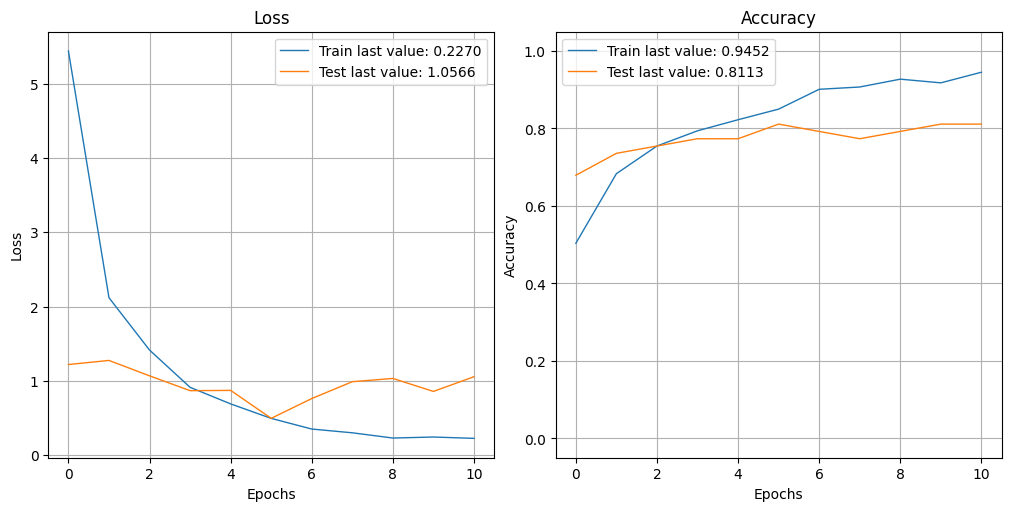

In [241]:
show_history(history3)
plot_history(history3, path="standard.png")
plt.savefig("images/graph/history_plot_model3.png")
plt.close()

<div style="background-color: #52be80;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.5. Approche nouvelle par Dataset avec data augmentation intégrée au modèle</h3>
</div>

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [242]:
# batch_size = 32

# def dataset_fct(path, validation_split=0, data_type=None) :
#     dataset = tensorflow.keras.utils.image_dataset_from_directory(
#                     path, labels='inferred', label_mode='categorical',
#                     class_names=None, batch_size=batch_size,
#                     image_size=(224, 224), shuffle=True, seed=42,
#                     validation_split=validation_split, subset=data_type
#                     )
#     return dataset

In [243]:
# dataset_train = dataset_fct(train_val_directory, validation_split=0.25,
#                             data_type='training')
# dataset_val = dataset_fct(train_val_directory, validation_split=0.25,
#                           data_type='validation')
# dataset_test = dataset_fct(test_directory, validation_split=0, data_type=None)

In [244]:
def resize_and_rescale(image, label):
    image = tensorflow.cast(image, tensorflow.float32)
    image = tensorflow.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [245]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet",
                       input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam',
                  metrics=["accuracy"])

    print(model.summary())
    
    return model

In [246]:
# Création du modèle
with tensorflow.device('/gpu:0'):
    model4 = create_model_fct2()

# Création du callback
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_7  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 256)               131328    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                      

In [247]:
print("Num GPUs Available: ", len(tensorflow.config
                                  .list_physical_devices('GPU')))

Num GPUs Available:  0


In [248]:
start_time = time.time() 

history4 = model4.fit(dataset_train,
                validation_data=dataset_val,
                batch_size=batch_size, epochs=50,
                callbacks=callbacks_list, verbose=1)

tps_exec_model4 = round(time.time() - start_time, 3)

Epoch 1/50
27/27 [==============================] - ETA: 0s - loss: 1.7840 - accuracy: 0.3202
Epoch 1: val_loss improved from inf to 1.37743, saving model to .\model4_best_weights.h5
27/27 [==============================] - 78s 3s/step - loss: 1.7840 - accuracy: 0.3202 - val_loss: 1.3774 - val_accuracy: 0.6604
Epoch 2/50
27/27 [==============================] - ETA: 0s - loss: 1.3000 - accuracy: 0.5869
Epoch 2: val_loss improved from 1.37743 to 1.07843, saving model to .\model4_best_weights.h5
27/27 [==============================] - 77s 3s/step - loss: 1.3000 - accuracy: 0.5869 - val_loss: 1.0784 - val_accuracy: 0.7170
Epoch 3/50
27/27 [==============================] - ETA: 0s - loss: 1.0612 - accuracy: 0.6595
Epoch 3: val_loss improved from 1.07843 to 0.91899, saving model to .\model4_best_weights.h5
27/27 [==============================] - 77s 3s/step - loss: 1.0612 - accuracy: 0.6595 - val_loss: 0.9190 - val_accuracy: 0.7358
Epoch 4/50
27/27 [==============================] - ETA:

In [249]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val,verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

27/27 [==============================] - 71s 3s/step - loss: 0.2552 - accuracy: 0.9167
Training Accuracy   : 0.9167

2/2 [==============================] - 5s 2s/step - loss: 0.6310 - accuracy: 0.7736
Validation Accuracy :  0.7736


In [250]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss_vali_model4, accuracy_vali_model4 = model4.evaluate(dataset_val,
                                                         verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_vali_model4))

loss_test_model4, accuracy_test_model4 = model4.evaluate(dataset_test,
                                                         verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_model4))

Validation Accuracy :  0.8113
Test Accuracy       :  0.7707


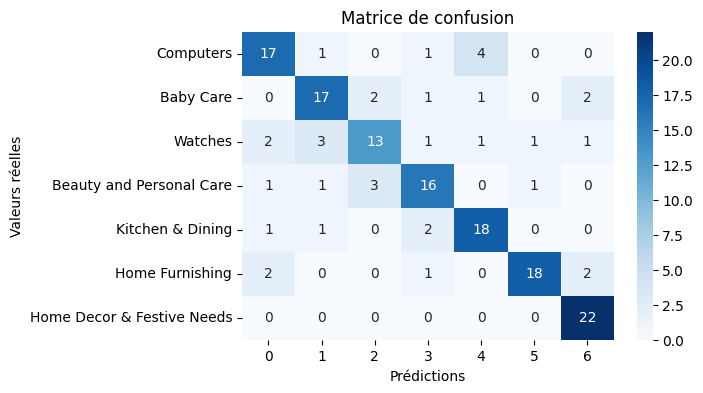

              precision    recall  f1-score   support

           0       0.74      0.74      0.74        23
           1       0.74      0.74      0.74        23
           2       0.72      0.59      0.65        22
           3       0.73      0.73      0.73        22
           4       0.75      0.82      0.78        22
           5       0.90      0.78      0.84        23
           6       0.81      1.00      0.90        22

    accuracy                           0.77       157
   macro avg       0.77      0.77      0.77       157
weighted avg       0.77      0.77      0.77       157



(0.16034257464332238, 0.1592356687898089, 0.15895251561211263, None)

In [334]:
evaluate_model_dataset(model4, dataset_test, name="model4")

In [251]:
# Information à garder pour la comparaison des performances

approach.append("New_approach_with_dataAugm")
loss_vali_opt.append(loss_vali_model4)
accuracy_vali_opt.append(accuracy_vali_model4)
loss_test_opt.append(loss_test_model4)
accuracy_test_opt.append(accuracy_test_model4)
time_fit.append(tps_exec_model4)

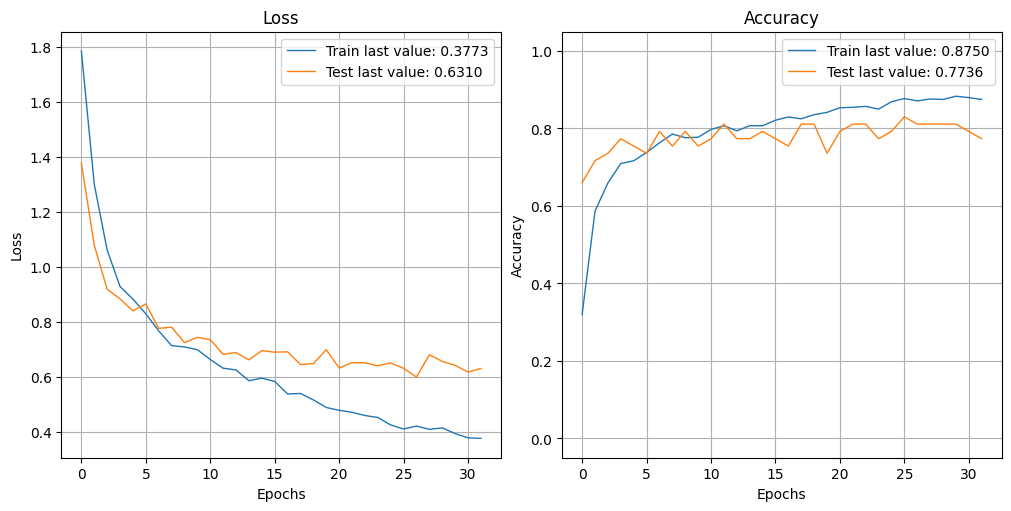

In [252]:
show_history(history4)
plot_history(history4, path="standard.png")
plt.savefig("images/graph/history_plot_model4.png")
plt.close()

<div style="background-color: #229954;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">4. Comparaison des performances</h2>
</div>

In [256]:
df_compar_perf = pd.DataFrame({
        "Approche": approach,
        "Loss_validation": loss_vali_opt,
        "Accuracy_validation": accuracy_vali_opt,
        "Loss_test": loss_test_opt,
        "Accuracy_test": accuracy_test_opt,
        "fit_time": time_fit}                     )

In [257]:
df_compar_perf=df_compar_perf.sort_values(by="Accuracy_test")
df_compar_perf

,Approche,Loss_validation,Accuracy_validation,Loss_test,Accuracy_test,fit_time
3,New_approach_with_dataAugm,0.599996,0.811321,0.714912,0.770701,2449.095
0,Prep_Init,0.785153,0.830189,0.837066,0.808917,886.849
2,New_approach_without_dataAugm,0.496663,0.811321,1.183772,0.815287,829.429
1,ImgDataGenerator,0.797854,0.773585,0.902380,0.821656,747.740


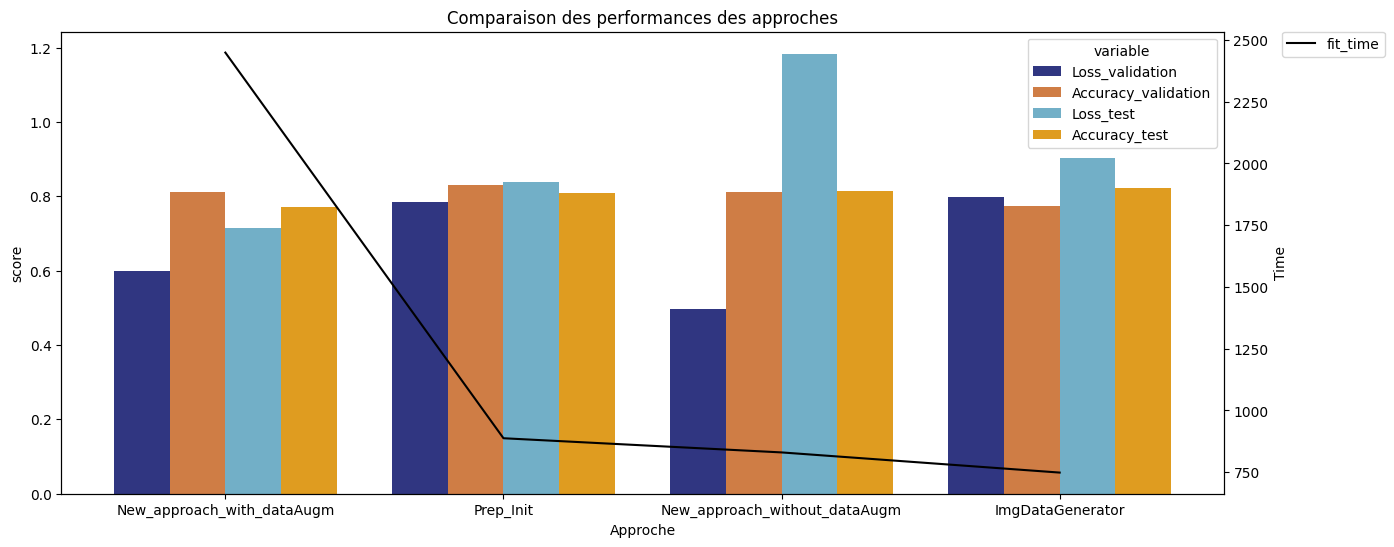

In [277]:
# Comparaison des algorithmes
comparaison_melt_wo_ft = pd.melt(df_compar_perf, id_vars=["Approche"],
                           value_name="score", value_vars=["Loss_validation",
                                                           "Accuracy_validation",
                                                           "Loss_test",
                                                           "Accuracy_test"
                                                           ])
comparaison_melt_ft = pd.melt(df_compar_perf, id_vars=["Approche"],
                           value_name="score", value_vars=["fit_time"])

# Visualisation
plt.figure(figsize=(15, 6))

sns.barplot(data=comparaison_melt_wo_ft,
            x=comparaison_melt_wo_ft["Approche"],
            y=comparaison_melt_wo_ft["score"], hue=comparaison_melt_wo_ft["variable"],
            palette=["#222b8f", "#e6792e", "#64b5d5", "#ffa600"])
# Creating secondary y-axis for fit_time
ax2 = plt.twinx()
sns.lineplot(x="Approche", y="score", hue="variable",
             data=comparaison_melt_ft,
             palette=["#000000"], ax=ax2)
plt.title("Comparaison des performances des approches", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)
ax2.set_ylabel("Time")
plt.savefig("images/graph/perf_comparing_N3.png")
plt.show()

In [264]:
comparaison_melt.shape

(20, 3)

In [270]:
comparaison_melt_v2.shape

(16, 3)